### Classifying movie review: a binary classification example
---
This notebook contains the code samples found in Chapter 3, Section 5 of Deep Learning with Python. Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.
Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews

### To install pytorch and torchtext which need in this HW

Type following code in cmd.
```
pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio==0.10.1 torchtext==0.11.1 -f https://download.pytorch.org/whl/torch_stable.html
```
This will install the pytorch with torchvision, torchaudio, torchtext that we will use for the rest of homeworks.

### The IMDG dataset
---
We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews

In [7]:
#!pip3 install torchtext==0.6.0

In [2]:
# Torch 버전 확인
import torchtext
torchtext.__version__

'0.6.0'

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

print(f'Number of training examples: {len(trainset)}')
print(f'Number of testing examples: {len(testset)}')

print(vars(trainset.examples[0]))

trainset, validset = trainset.split(random_state = random.seed(0))

Number of training examples: 25000
Number of testing examples: 25000
{'text': ['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"teachers".', 'my', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', "high's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"teachers".', 'the', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students.', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'i', 'immediately', 'recalled', '.........', 'at', '..........', 'high.', 'a', 'classic

In [4]:
import pandas as pd
import numpy as np

data_frame = pd.DataFrame(trainset.examples, columns=['text'])
data_frame.head()

,text
0,<torchtext.data.example.Example object at 0x00...
1,<torchtext.data.example.Example object at 0x00...
2,<torchtext.data.example.Example object at 0x00...
3,<torchtext.data.example.Example object at 0x00...
4,<torchtext.data.example.Example object at 0x00...


In [5]:
MAX_VOCAB_SIZE = 9998

TEXT.build_vocab(trainset, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(trainset)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")


Unique tokens in TEXT vocabulary: 10000
Unique tokens in LABEL vocabulary: 3


In [6]:
from typing import Text

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (trainset, validset, testset), 
    batch_size = BATCH_SIZE,
    device = device)

print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

cpu와 cuda 중 다음 기기로 학습함: cpu
Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


### Buliding our network
---
Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of network that performs well on such a problem would be a simple stack of fully-connected (Dense) layers with relu activations: Dense(16, 
activation='relu')

Having 16 hidden units means that the weight matrix W will have shape (input_dimension, 16), i.e. the dot product with W will project the input data onto a 16-dimensional representation space (and then we would add the bias vector b and apply the relu operation). You can intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

How many layers to use.
How many "hidden units" to chose for each layer.

In [7]:
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 16)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))

        return x
        
model = Model()
model.to(device)
print(model)

# 하이퍼파라미터 튜닝
optimizer = optim.RMSprop(params = model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.BCELoss()
metrics = sklearn.metrics.accuracy_score

# 벡터화
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

Model(
  (fc1): Linear(in_features=10000, out_features=16, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (act3): Sigmoid()
)


In [8]:
# 학습

history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(20):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_iterator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_correct += ((outputs>0.5) == (labels>0.5)).sum()
        running_total += labels.size(0)

    for i, data in enumerate(valid_iterator, 0):
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        running_val_correct += ((outputs>0.5) == (labels>0.5)).sum()            
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_iterator):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_iterator):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_iterator))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_iterator))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   118] loss: 0.401, accuracy: 0.8362, val_loss: 0.299, valid accuracy: 0.8759
[2,   118] loss: 0.187, accuracy: 0.9250, val_loss: 0.335, valid accuracy: 0.8681
[3,   118] loss: 0.098, accuracy: 0.9623, val_loss: 0.444, valid accuracy: 0.8636
[4,   118] loss: 0.051, accuracy: 0.9798, val_loss: 0.848, valid accuracy: 0.8653
[5,   118] loss: 0.034, accuracy: 0.9859, val_loss: 0.756, valid accuracy: 0.8577
[6,   118] loss: 0.030, accuracy: 0.9883, val_loss: 1.222, valid accuracy: 0.8632
[7,   118] loss: 0.022, accuracy: 0.9895, val_loss: 1.732, valid accuracy: 0.8620
[8,   118] loss: 0.023, accuracy: 0.9922, val_loss: 1.589, valid accuracy: 0.8615
[9,   118] loss: 0.013, accuracy: 0.9942, val_loss: 1.849, valid accuracy: 0.8616
[10,   118] loss: 0.017, accuracy: 0.9933, val_loss: 1.654, valid accuracy: 0.8605
[11,   118] loss: 0.014, accuracy: 0.9942, val_loss: 2.172, valid accuracy: 0.8563
[12,   118] loss: 0.012, accuracy: 0.9953, val_loss: 2.993, valid accuracy: 0.8516
[13,   118] l

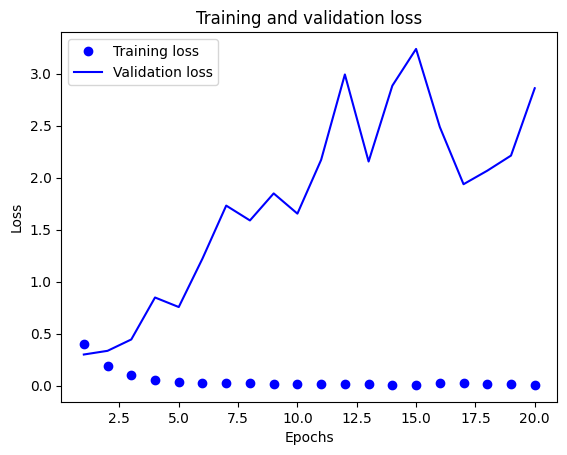

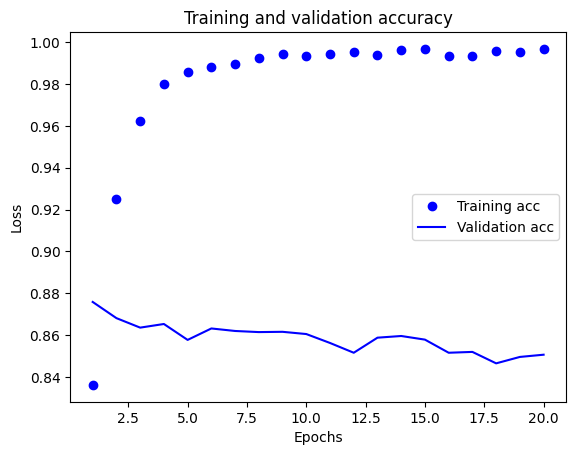

In [9]:
# 결과 시각화

import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()   # clear figure


acc_values = acc
val_acc_values = val_acc

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Further Experience 1
### optimizer 바꿔보기: Adam으로 변경

In [9]:
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics

class Model_exp1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 16)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))

        return x
        
model = Model_exp1()
model.to(device)
print(model)

# 하이퍼파라미터 튜닝
optimizer = optim.Adam(params = model.parameters(), lr = 0.001,)
criterion = nn.BCELoss()
metrics = sklearn.metrics.accuracy_score

# 벡터화
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

Model_exp1(
  (fc1): Linear(in_features=10000, out_features=16, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (act3): Sigmoid()
)


In [10]:
# 학습

history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(20):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_iterator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_correct += ((outputs>0.5) == (labels>0.5)).sum()
        running_total += labels.size(0)

    for i, data in enumerate(valid_iterator, 0):
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        running_val_correct += ((outputs>0.5) == (labels>0.5)).sum()            
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_iterator):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_iterator):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_iterator))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_iterator))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   118] loss: 0.409, accuracy: 0.8231, val_loss: 0.298, valid accuracy: 0.8784
[2,   118] loss: 0.198, accuracy: 0.9243, val_loss: 0.318, valid accuracy: 0.8767
[3,   118] loss: 0.134, accuracy: 0.9537, val_loss: 0.375, valid accuracy: 0.8679
[4,   118] loss: 0.088, accuracy: 0.9715, val_loss: 0.457, valid accuracy: 0.8669
[5,   118] loss: 0.063, accuracy: 0.9803, val_loss: 0.583, valid accuracy: 0.8529
[6,   118] loss: 0.047, accuracy: 0.9848, val_loss: 0.712, valid accuracy: 0.8568
[7,   118] loss: 0.034, accuracy: 0.9890, val_loss: 0.805, valid accuracy: 0.8533
[8,   118] loss: 0.028, accuracy: 0.9918, val_loss: 0.998, valid accuracy: 0.8537
[9,   118] loss: 0.019, accuracy: 0.9943, val_loss: 1.295, valid accuracy: 0.8545
[10,   118] loss: 0.010, accuracy: 0.9974, val_loss: 1.475, valid accuracy: 0.8513
[11,   118] loss: 0.005, accuracy: 0.9991, val_loss: 1.462, valid accuracy: 0.8497
[12,   118] loss: 0.003, accuracy: 0.9996, val_loss: 1.713, valid accuracy: 0.8516
[13,   118] l

## Further Experience 2
### activation function 바꿔보기: GELU로 변경

In [11]:
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics

class Model_exp2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 16)
        self.act1 = nn.GELU()
        self.fc2 = nn.Linear(16, 16)
        self.act2 = nn.GELU()
        self.fc3 = nn.Linear(16, 1)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))

        return x
        
model = Model_exp2()
model.to(device)
print(model)

# 하이퍼파라미터 튜닝
optimizer = optim.Adam(params = model.parameters(), lr = 0.001,)
criterion = nn.BCELoss()
metrics = sklearn.metrics.accuracy_score

# 벡터화
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

Model_exp2(
  (fc1): Linear(in_features=10000, out_features=16, bias=True)
  (act1): GELU(approximate='none')
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (act2): GELU(approximate='none')
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (act3): Sigmoid()
)


In [12]:
# 학습

history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(20):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_iterator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_correct += ((outputs>0.5) == (labels>0.5)).sum()
        running_total += labels.size(0)

    for i, data in enumerate(valid_iterator, 0):
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        running_val_correct += ((outputs>0.5) == (labels>0.5)).sum()            
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_iterator):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_iterator):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_iterator))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_iterator))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   118] loss: 0.395, accuracy: 0.8281, val_loss: 0.288, valid accuracy: 0.8839
[2,   118] loss: 0.192, accuracy: 0.9298, val_loss: 0.319, valid accuracy: 0.8800
[3,   118] loss: 0.129, accuracy: 0.9547, val_loss: 0.376, valid accuracy: 0.8721
[4,   118] loss: 0.089, accuracy: 0.9705, val_loss: 0.493, valid accuracy: 0.8657
[5,   118] loss: 0.062, accuracy: 0.9803, val_loss: 0.584, valid accuracy: 0.8621
[6,   118] loss: 0.042, accuracy: 0.9867, val_loss: 0.692, valid accuracy: 0.8527
[7,   118] loss: 0.033, accuracy: 0.9898, val_loss: 0.870, valid accuracy: 0.8544
[8,   118] loss: 0.023, accuracy: 0.9938, val_loss: 0.979, valid accuracy: 0.8536
[9,   118] loss: 0.021, accuracy: 0.9942, val_loss: 1.204, valid accuracy: 0.8509
[10,   118] loss: 0.020, accuracy: 0.9937, val_loss: 1.329, valid accuracy: 0.8501
[11,   118] loss: 0.026, accuracy: 0.9907, val_loss: 1.420, valid accuracy: 0.8491
[12,   118] loss: 0.031, accuracy: 0.9887, val_loss: 1.579, valid accuracy: 0.8479
[13,   118] l

## Further Experience 3
### loss function 바꿔보기: Cross-entropy로 변경

In [13]:
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics

class Model_exp3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 16)
        self.act1 = nn.GELU()
        self.fc2 = nn.Linear(16, 16)
        self.act2 = nn.GELU()
        self.fc3 = nn.Linear(16, 1)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))

        return x
        
model = Model_exp3()
model.to(device)
print(model)

# 하이퍼파라미터 튜닝
optimizer = optim.RMSprop(params = model.parameters(), lr = 0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()
metrics = sklearn.metrics.accuracy_score

# 벡터화
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

Model_exp2(
  (fc1): Linear(in_features=10000, out_features=16, bias=True)
  (act1): GELU(approximate='none')
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (act2): GELU(approximate='none')
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (act3): Sigmoid()
)


In [14]:
# 학습

history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(20):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_iterator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_correct += ((outputs>0.5) == (labels>0.5)).sum()
        running_total += labels.size(0)

    for i, data in enumerate(valid_iterator, 0):
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        running_val_correct += ((outputs>0.5) == (labels>0.5)).sum()            
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_iterator):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_iterator):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_iterator))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_iterator))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[2,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[3,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[4,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[5,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[6,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[7,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[8,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[9,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[10,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[11,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[12,   118] loss: 0.000, accuracy: 0.5017, val_loss: 0.000, valid accuracy: 0.4961
[13,   118] l

## Further Experience 4
### Layer 수 늘려보기

In [15]:
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics

class Model_exp4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 256)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 16)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(16, 1)
        self.act4 = nn.Sigmoid()
        

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.act4(self.fc4(x))

        return x
        
model = Model_exp4()
model.to(device)
print(model)

# 하이퍼파라미터 튜닝
optimizer = optim.RMSprop(params = model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.BCELoss()
metrics = sklearn.metrics.accuracy_score

# 벡터화
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

Model_exp4(
  (fc1): Linear(in_features=10000, out_features=256, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=256, out_features=16, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (act4): Sigmoid()
)


In [16]:
# 학습

history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(20):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_iterator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_correct += ((outputs>0.5) == (labels>0.5)).sum()
        running_total += labels.size(0)

    for i, data in enumerate(valid_iterator, 0):
        inputs, labels = data.text, data.label
        inputs = vectorize_sequences(inputs.cpu())
        inputs = torch.tensor(inputs, device=device).float()
        labels = labels.view(-1, 1).float().sub_(1)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        running_val_correct += ((outputs>0.5) == (labels>0.5)).sum()            
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_iterator):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_iterator):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_iterator))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_iterator))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   118] loss: 0.371, accuracy: 0.8373, val_loss: 0.326, valid accuracy: 0.8716
[2,   118] loss: 0.180, accuracy: 0.9313, val_loss: 0.327, valid accuracy: 0.8609
[3,   118] loss: 0.097, accuracy: 0.9647, val_loss: 0.532, valid accuracy: 0.8631
[4,   118] loss: 0.042, accuracy: 0.9859, val_loss: 0.862, valid accuracy: 0.8668
[5,   118] loss: 0.033, accuracy: 0.9904, val_loss: 1.080, valid accuracy: 0.8639
[6,   118] loss: 0.025, accuracy: 0.9914, val_loss: 1.458, valid accuracy: 0.8680
[7,   118] loss: 0.022, accuracy: 0.9935, val_loss: 2.042, valid accuracy: 0.8516
[8,   118] loss: 0.035, accuracy: 0.9907, val_loss: 0.949, valid accuracy: 0.8557
[9,   118] loss: 0.022, accuracy: 0.9947, val_loss: 5.336, valid accuracy: 0.8568
[10,   118] loss: 0.043, accuracy: 0.9958, val_loss: 2.511, valid accuracy: 0.8605
[11,   118] loss: 0.015, accuracy: 0.9971, val_loss: 5.411, valid accuracy: 0.8643
[12,   118] loss: 0.030, accuracy: 0.9962, val_loss: 4.388, valid accuracy: 0.8617
[13,   118] l

### Using a trained network to generate predictions on new data

In [53]:
data = next(iter(test_iterator))
inputs, labels = data.text, data.label
inputs = vectorize_sequences(inputs.cpu())
inputs = torch.tensor(inputs, device=device).float()

model(inputs)

tensor([[1.0000e+00],
        [1.4976e-01],
        [4.5408e-01],
        [4.5408e-01],
        [4.5408e-01],
        [1.3836e-01],
        [1.0000e+00],
        [2.4838e-02],
        [9.9991e-01],
        [1.0000e+00],
        [7.6102e-01],
        [3.7860e-07],
        [1.9094e-05],
        [4.5171e-05],
        [3.7482e-04],
        [4.5408e-01],
        [9.5376e-01],
        [4.5408e-01],
        [1.0000e+00],
        [1.0013e-01],
        [9.5741e-01],
        [5.7956e-11],
        [1.3273e-10],
        [4.5408e-01],
        [1.0000e+00],
        [6.1639e-09],
        [9.9847e-01],
        [4.5408e-01],
        [4.5408e-01],
        [9.9925e-01],
        [4.5518e-01],
        [2.7152e-16],
        [8.9660e-01],
        [1.1146e-09],
        [4.5408e-01],
        [9.7039e-03],
        [4.5408e-01],
        [5.3734e-08],
        [3.7548e-06],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [2.5684e-05],
        [8.1883e-01],
        [1.0057e-02],
        [1

### Further experiments
- We were using 2 hidden layers. Try to use 1 or 3 hidden layers and see how it affects validation and test accuracy.
- Try to use layers with more hidden units or less hidden units: 32 units, 64 units...
- Try to use the mse loss function instead of binary_crossentropy.
- Try to use the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.

These experiments will help convince you that the architecture choices we have made are all fairly reasonable, although they can still be improved!

### Conclusions
Here's what you should take away from this example:
- There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
- Stacks of Dense layers with relu activations can solve a wide range of problems (including sentiment classification), and you will likely use them frequently.
- In a binary classification problem (two output classes), your network should end with a Dense layer with 1 unit and a sigmoid activation, i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
- With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is binary_crossentropy.
- The rmsprop optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry about.
- As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data never-seen-before. Make sure to always monitor performance on data that is outside of the training set.
